In [1]:
import numpy as np
import librosa
import pickle
import pandas as pd
import random
from math import floor

In [5]:
# Utility function to load a pickle file
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def beat_tracking_dp(y, sr, hop_length=512, alpha=0.5):
    """Perform beat tracking using dynamic programming."""
    tempo_estimate, _ = librosa.beat.beat_track(y=y, sr=sr)
    floor_tempo = floor(tempo_estimate)
    tempo_hypotheses = [floor_tempo - 1, floor_tempo, tempo_estimate, floor_tempo + 1]
    tempo_hypotheses = np.unique(tempo_hypotheses)

    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    time_step = hop_length / sr
    time_grid = np.arange(len(onset_env)) * time_step
    C = np.zeros((len(onset_env), len(tempo_hypotheses)))
    P = np.zeros_like(C, dtype=int)

    for i, t in enumerate(time_grid[1:], 1):
        for k, tempo in enumerate(tempo_hypotheses):
            tau_p = 60 / tempo
            start = max(0, i - int(2 * tau_p / time_step))
            end = max(0, i - int(tau_p / (2 * time_step)))
            if start < end:
                transition_scores = C[start:end, k] - alpha * (np.log((t - time_grid[start:end]) / tau_p))**2
                best_predecessor = start + np.argmax(transition_scores)
                max_score = transition_scores[best_predecessor - start]
            else:
                best_predecessor = 0
                max_score = 0
            C[i, k] = onset_env[i] + max_score
            P[i, k] = best_predecessor

    best_tempo_index = np.argmax(C[-1])
    best_bpm = tempo_hypotheses[best_tempo_index]

    # Backtrace to recover the beat sequence
    beat_frames = [len(onset_env) - 1]  # Start from the last frame
    current_frame = beat_frames[-1]

    while current_frame > 0:
        current_frame = P[current_frame, best_tempo_index]
        beat_frames.append(current_frame)

    beat_frames.pop()  # Remove the last appended frame which is zero due to initialization
    beat_frames.reverse()  # Reverse the beat frames to be in chronological order

    return best_bpm, beat_frames, tempo_estimate

In [6]:
df = pd.read_csv('../data/dataframes/clean_labeled.csv') 
X_test = load_pickle('../data/pkl/test_data.pkl')

random.seed(42)
random_song_id = int(random.choice(list(X_test.keys())))
audio_file = f'../data/audio_files/processed/{random_song_id}.mp3'
y, sr = librosa.load(audio_file, sr=None)
tempo, beats, original_bpm = beat_tracking_dp(y, sr=sr)
print("Song ID:", random_song_id)
print("Best BPM estimate:", tempo)
print("Original BPM estimate:", original_bpm)
print("Spotify BPM:", df.loc[df['SongID'] == random_song_id]['sp_tempo'].values[0])
print("Beat frames:", beats)

Song ID: 71
Best BPM estimate: 126.0
Original BPM estimate: 125.0
Spotify BPM: 125.99
Beat frames: [89, 160, 205, 272, 340, 410, 474, 541, 592, 652, 741, 830, 875, 920, 1008, 1097, 1142, 1187, 1276, 1365, 1455, 1544, 1633, 1722, 1768, 1835, 1901, 1990, 2080, 2169, 2258, 2347, 2392, 2437, 2482, 2549, 2616, 2683, 2749, 2794, 2839, 2884, 2929, 2974, 3060, 3106, 3151, 3218, 3284, 3329, 3418, 3463, 3508, 3575, 3642, 3687, 3775, 3820, 3865, 3910, 3998, 4043, 4132, 4177, 4222, 4267, 4312, 4357, 4445, 4490, 4535, 4580, 4625, 4712, 4757, 4802, 4891, 4936, 4981, 5026, 5071, 5159, 5204, 5249, 5294, 5339, 5427, 5472, 5517, 5605, 5650, 5695, 5784, 5829, 5918, 5963, 6008, 6053, 6141, 6186, 6231, 6276, 6321, 6409, 6454, 6499, 6544, 6589, 6677, 6722, 6767, 6855, 6900, 6989, 7034, 7079, 7124, 7169, 7214, 7302, 7347, 7392, 7437, 7482, 7569, 7614, 7659, 7748, 7793, 7838, 7883, 7928, 7973, 8061, 8106, 8151, 8196, 8284, 8329, 8374, 8463, 8508, 8553, 8598, 8643, 8688, 8755, 8820, 8865, 8910, 8978, 9044, 908

In [98]:
import os
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import librosa

# Set the number of OpenMP threads to 2
os.environ["OMP_NUM_THREADS"] = "2"

# Load a song and its corresponding data
random_song_id = 37
audio_file = f'../data/audio_files/processed/{random_song_id}.mp3'
df = pd.read_csv('../data/dataframes/clean_labeled.csv')
data = df.loc[df['SongID'] == random_song_id]

# Load audio file and separate harmonic and percussive components
y, sr = librosa.load(audio_file, sr=None)
y_perc = librosa.effects.hpss(y)[1]
onset_env = librosa.onset.onset_strength(y=y_perc, sr=sr, hop_length=512)

# Calculate the pulse and find local maxima
pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr, tempo_min=30, tempo_max=600, win_length=834)
local_maxima = librosa.util.localmax(pulse)
pulse_times = librosa.frames_to_time(np.flatnonzero(local_maxima), sr=sr)
pulse_intervals = np.diff(pulse_times).reshape(-1, 1)

# Apply k-means clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
clusters = kmeans.fit_predict(pulse_intervals)

# Function to find the longest sequence in a cluster
def find_longest_sequence_in_cluster(cluster_label, clusters, pulse_times):
    """Find the longest sequence of consecutive numbers in a cluster."""
    indices = np.where(clusters == cluster_label)[0]
    if len(indices) == 0:
        return None, None  # Handle case where a cluster may have no elements
    longest_sequence = []
    current_sequence = [indices[0]]

    for i in range(1, len(indices)):
        if indices[i] == indices[i - 1] + 1:
            current_sequence.append(indices[i])
        else:
            if len(current_sequence) > len(longest_sequence):
                longest_sequence = current_sequence
            current_sequence = [indices[i]]
    if len(current_sequence) > len(longest_sequence):
        longest_sequence = current_sequence

    # Return the start and end time of the longest sequence
    return pulse_times[longest_sequence[0]], pulse_times[longest_sequence[-1]], indices

# Dictionary to hold the data for each cluster
clusters_info = {}

# Find the longest sequence and calculate the tempo for each cluster
for cluster_label in range(n_clusters):
    start_time, end_time, cluster_indices = find_longest_sequence_in_cluster(cluster_label, clusters, pulse_times)
    
    if start_time is not None and end_time is not None:
        # Extract the percussive component for the longest sequence
        start_sample = librosa.time_to_samples(start_time, sr=sr)
        end_sample = librosa.time_to_samples(end_time, sr=sr)
        y_perc_segment = y_perc[start_sample:end_sample]
        
        # Estimate the tempo of the segment
        tempo = librosa.feature.tempo(y=y_perc_segment, sr=sr, hop_length=512, max_tempo=140, ac_size=4.0)[0]
        
        # Store the information in the dictionary
        pulse_times_in_cluster = pulse_times[cluster_indices]  # Get pulse times for current cluster
        clusters_info[cluster_label] = {
            'pulse_times': pulse_times_in_cluster.tolist(),  # Store pulse times for the cluster
            'longest_seq_times': (start_time, end_time),
            'longest_seq_tempo': tempo
        }
    else:
        # Store empty information if no sequence is found
        clusters_info[cluster_label] = {
            'pulse_times': [],
            'longest_seq_times': (None, None),
            'longest_seq_tempo': None
        }

In [9]:
librosa.feature.tempo(y=y, sr=sr, hop_length=512, max_tempo=140)

array([125.])

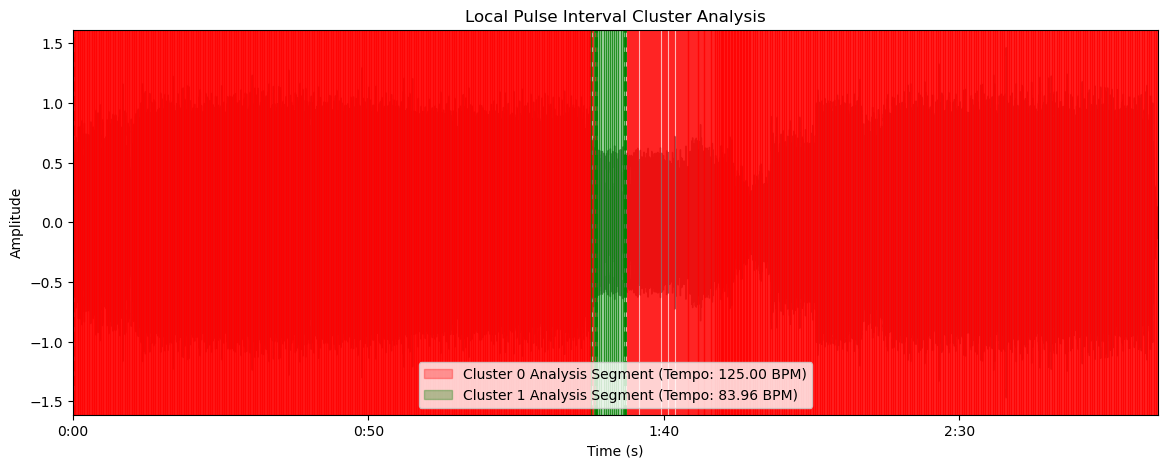

In [99]:
# Define a color map for clusters
colors = ['red', 'green', 'blue']
assert len(colors) >= len(clusters_info), "Not enough colors for the number of clusters"

plt.figure(figsize=(14, 5))
duration = librosa.get_duration(y=y, sr=sr)
librosa.display.waveshow(y, sr=sr, color='grey')

# Iterate through each cluster to plot the segments
for cluster_label, info in zip(clusters_info.keys(), clusters_info.values()):
    cluster_color = colors[cluster_label % len(colors)]  # Use modulo to cycle through colors
    pulse_times = info['pulse_times']
    start_time, end_time = info['longest_seq_times']
    tempo = info['longest_seq_tempo']
    
    # Plot the pulse times for each cluster
    for pt in pulse_times:
        plt.axvline(x=pt, color=cluster_color, linestyle='-', linewidth=1, alpha=0.8)
    
    # Plot the start and end markers for the longest sequence in the cluster
    if start_time is not None and end_time is not None:
        plt.axvline(x=start_time, color=cluster_color, linestyle='--', linewidth=2)
        plt.axvline(x=end_time, color=cluster_color, linestyle='--', linewidth=2)
        plt.axvspan(start_time, end_time, color=cluster_color, alpha=0.3, label=f'Cluster {cluster_label} Analysis Segment (Tempo: {tempo:.2f} BPM)')

# Add labels and legend
plt.title('Local Pulse Interval Cluster Analysis')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, duration)
plt.legend()

# Show the plot
plt.show()

---

The following code reproduces the tempo estimation method outlined in [Template-Based Estimation of Time-Varying Tempo](https://asp-eurasipjournals.springeropen.com/articles/10.1155/2007/67215). 

Steps:
1) Obtain the onset-energy function.
2) Compute the reassigned spectrogram and the reassigned spectral energy flux: 
3) Estimate the periodicities using the combined DFT and FM-ACF method.
4) Apply the Viterbi decoding algorithm to estimate tempo and meter/beat subdivisions.

# 1) Obtain the onset-energy function.

Preprocessing: Downsample the audio signal to 11.025 Hz and convert it to mono.

Reassigned Spectrogram: Compute the reassigned spectrogram using a Hamming window of 92.8 ms (1023 samples) to achieve good frequency resolution. This step enhances both temporal and frequency resolution, which is crucial for accurate onset detection.

Spectral Energy Flux:
- Convert the energy spectrum to a logarithmic scale and apply a threshold of 50 dB below the maximum energy to focus on significant changes.
- Apply a low-pass filter with an elliptic filter of order 5 and a cutoff frequency of 10 Hz to the log-scale energy spectrum. This step helps in reducing noise and emphasizing meaningful energy changes.
- Differentiate the filtered energy signals using a simple [1, -1] differentiator and perform half-wave rectification.
- Sum the rectified signals over all frequency bands to obtain the onset energy function.

Onset Energy Function: The final onset energy function is sampled at 172 Hz, providing a fine temporal resolution for detecting onsets.

---

In [114]:
# Import necessary libraries
import numpy as np
import librosa
import random
import pickle
from scipy.fft import fft, ifft, rfftfreq
from scipy.signal import correlate, find_peaks, fftconvolve, hamming, get_window, spectrogram, butter, sosfiltfilt, ellip
from numpy import interp

In [93]:
# Load sample audio file
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)
    
X_test = load_pickle('../data/pkl/test_data.pkl')
random.seed(42)
random_song_id = int(random.choice(list(X_test.keys())))
audio_file = f'../data/audio_files/processed/{random_song_id}.mp3'

y, sr = librosa.load(audio_file, sr=None)

In [94]:
# Downsample audio and convert to mono
def preprocess_audio(y, sr, target_sr=11025):
    return librosa.resample(y=y, orig_sr=sr, target_sr=target_sr), target_sr
    
y, sr = preprocess_audio(y, sr, target_sr=11025)

In [121]:
def compute_reassigned_spectrogram(y, sr, win_length_ms=92.8, epsilon = 1e-10):
    # Downsample the signal to 11.025 Hz
    y = librosa.resample(y, orig_sr=sr, target_sr=11025)
    sr = 11025
    # Convert window length from milliseconds to samples
    win_length = int(sr * win_length_ms / 1000)
    
    # Define the Hamming window
    window = scipy.signal.hamming(win_length, sym=False)
    
    # Define the analysis window h
    h = scipy.signal.hamming(win_length, sym=False)
        
    # Compute the time derivative of the Hamming window
    dh = np.diff(h) / np.diff(np.arange(-win_length//2, win_length//2))
    dh = np.pad(dh, (1, 0), 'constant') # Pad with zero to match the original window length
    
    # Compute the STFT using the original window h 
    STFTh = librosa.stft(y, n_fft=win_length, win_length=win_length, window=h, hop_length=win_length//2, center=True)
    
    # Compute the STFT using the derivative of the window dh 
    STFTdh = librosa.stft(y, n_fft=win_length, win_length=win_length, window=dh, hop_length=win_length//2, center=True)

    # Calculate the instantaneous frequency
    # The phase of STFTh
    phase_h = np.angle(STFTh)
    
    # The time derivative of the phase
    d_phase_h = np.diff(phase_h, axis=1)
    d_phase_h = np.pad(d_phase_h, ((0, 0), (1, 0)), mode='constant')  # Pad to maintain shape
    
    # The instantaneous frequency
    inst_freq = np.unwrap(d_phase_h) / (np.pi * 2)
    
    # Calculate the reassignment vectors for frequency and time
    reassignment_freq = np.imag(STFTdh / (STFTh + epsilon))
    reassignment_time = np.real(STFTdh / (STFTh + epsilon))
    
    # Calculate the reassigned frequency and time coordinates
    freqs = librosa.fft_frequencies(sr=sr, n_fft=win_length)
    # Reshape freqs to match the shape of reassignment_freq for broadcasting
    freqs = freqs[:, np.newaxis]
    times = librosa.frames_to_time(np.arange(STFTh.shape[1]), sr=sr, hop_length=win_length//2)
    
    reassigned_freqs = freqs + reassignment_freq * sr / (2 * np.pi)
    reassigned_times = times + reassignment_time * win_length / sr
    
    # Round ω_r and t_r to the closest discrete frequency and time on the STFT grid 
    reassigned_freqs = np.round(reassigned_freqs / (sr / win_length)) * (sr / win_length)
    reassigned_times = np.round(reassigned_times / (win_length / sr)) * (win_length / sr)
    
    # Compute the reassigned spectrogram
    mags = np.abs(STFTh)
    
    return reassigned_freqs, reassigned_times, mags

def compute_spectral_flux(y, sr=11025):
    # Compute the reassigned spectrogram
    reassigned_freqs, reassigned_times, mags = compute_reassigned_spectrogram(y, sr)
    
    # Log scale and threshold
    magnitude_spectrogram = np.abs(mags)
    D_log = librosa.amplitude_to_db(magnitude_spectrogram, ref=np.max(magnitude_spectrogram))
    D_log[D_log < -50] = -50  # Thresholding
    
    # Generate the SOS low-pass filter
    sos = ellip(5, 0.1, 40, 10/(sr/2), btype='low', output='sos')
    
    # Apply the SOS filter using sosfiltfilt
    D_filtered = sosfiltfilt(sos, D_log, axis=1)  # Note: axis correction to 1 for time-series filtering
    
    # Differentiate and half-wave rectify
    D_diff = np.diff(D_filtered, axis=1, prepend=np.zeros(D_filtered.shape[0]).reshape(-1, 1))
    D_hwr = np.maximum(0, D_diff)
    
    # Sum over frequency bands to compute the spectral flux
    spectral_flux = np.sum(D_hwr, axis=0)
    
    return spectral_flux

reassigned_freqs, reassigned_times, mags = compute_reassigned_spectrogram(y, sr)
spectral_flux = compute_spectral_flux(y, sr)
spectral_flux

array([0.        , 3.58239611, 3.58318745, ..., 0.00567769, 0.00541212,
       0.0051454 ])

In [122]:
def windowed_dft_acf(segment, sr):
    """
    Calculate the windowed DFT and ACF for a given segment of spectral flux.
    """
    dft_spectrum = fft(segment)
    dft_magnitude = np.abs(dft_spectrum)
    
    acf = ifft(dft_spectrum * np.conj(dft_spectrum)).real
    acf = acf[:len(segment)]  # Keep autocorrelation result up to window size
    
    return dft_magnitude, acf

def estimate_periodicity(spectral_flux, sr=11025, min_bpm=30, max_bpm=600, n_fft = 8192, hop_length = 512):
    window_size = n_fft
    hop_size = hop_length
    
    segments = [spectral_flux[i:i+window_size] for i in range(0, len(spectral_flux) - window_size + 1, hop_size)]
    
    bpm_range = np.arange(min_bpm, max_bpm + 1)
    
    combined_measure = np.zeros(int((max_bpm - min_bpm + 1)))
    
    for segment in segments:
        if np.all(segment == 0):
            continue  # Skip segments that are all zeros
        
        dft_magnitude, acf = windowed_dft_acf(segment, sr)
        
        freqs_for_bpm = bpm_range / 60  # Convert BPM to Hz
        
        # Calculate DFT frequencies for mapping
        dft_freqs = rfftfreq(len(segment), d=1/sr)
        
        acf_adjusted = acf[:len(dft_freqs)]
        
        # Interpolate DFT magnitude and adjusted ACF to BPM range
        dft_to_bpm_mapping = np.interp(freqs_for_bpm, dft_freqs, dft_magnitude[:len(dft_freqs)], left=0, right=0)
        acf_to_bpm_mapping = np.interp(freqs_for_bpm, dft_freqs, acf_adjusted, left=0, right=0)
        
        combined_measure += dft_to_bpm_mapping* + acf_to_bpm_mapping
    
    if np.max(combined_measure) > 0:
        combined_measure /= np.max(combined_measure)  # Normalize the combined measure
    else:
        return []  # Return empty if the combined measure is all zeros

    peaks, properties = find_peaks(combined_measure, height=0.1, distance=1)
    tempos = bpm_range[peaks]
    strengths = properties['peak_heights']
    tempo_info = list(zip(tempos, strengths))
    
    return tempo_info if tempo_info else []

tempo_info = estimate_periodicity(spectral_flux, sr)
tempo_info

[]

In [109]:
def windowed_dft_acf(segment, sr):
    dft_spectrum = fft(segment)
    dft_magnitude = np.abs(dft_spectrum)
    
    acf = ifft(dft_spectrum * np.conj(dft_spectrum)).real
    acf = acf[:len(segment)]  
    
    return dft_magnitude, acf

window_sec=3
hop_sec=0.5
max_bpm = 600
min_bpm = 30

window_size = int(window_sec * sr)
hop_size = int(hop_sec * sr)
segments = [spectral_flux[i:i+window_size] for i in range(0, len(spectral_flux) - window_size + 1, hop_size)]

window_size, hop_size

(33075, 5512)

In [79]:
D

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[3.5404542e-04, 3.5085244e-04, 7.0788595e-04, ..., 9.8698374e-06,
         7.9997436e-10, 0.0000000e+00],
        [3.5292463e-04, 5.4356363e-04, 8.1768417e-04, ..., 9.5051964e-06,
         8.0026924e-10, 0.0000000e+00],
        [3.4562810e-04, 6.2088901e-04, 7.8631949e-04, ..., 8.5621732e-06,
         8.0099199e-10, 0.0000000e+00],
        ...,
        [5.5590345e-07, 3.3657167e-07, 4.6476248e-07, ..., 1.8099207e-08,
 

In [52]:
# Load sample audio file
def load_pickle(file_path):
    """Load data from a pickle file."""
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def reassign_bins(magnitude, freq_bins, time_frames, delta_t, delta_f, stft_derivative_time, sr, hop_length):
    # Convert time and frequency reassignments to absolute units
    epsilon = 1e-8
    delta_t = np.real(stft_derivative_time) / (magnitude + epsilon) * (2 * np.pi)

    # When computing the reassigned indices, handle `NaN` values before rounding and clipping:
    time_reassigned = np.nan_to_num(time_reassigned, nan=0.0, posinf=0.0, neginf=0.0)
    freq_reassigned = np.nan_to_num(freq_reassigned, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Round to the nearest bin indices within the bounds
    time_indices = np.clip(np.rint(time_reassigned / hop_length), 0, len(time_frames) - 1).astype(int)
    freq_indices = np.clip(np.rint(freq_reassigned / (sr / magnitude.shape[0] * 2)), 0, magnitude.shape[0] - 1).astype(int)
    
    # Accumulate energy into the reassigned bins
    reassigned_spectrogram = np.zeros_like(magnitude)
    for i in range(len(freq_bins)):
        for j in range(len(time_frames)):
            reassigned_spectrogram[freq_indices[i, j], time_indices[i, j]] += magnitude[i, j]
    
    return reassigned_spectrogram

def instantaneous_frequency(phase, hop_length, sr):
    # Compute the first-order difference of the phase along the time axis
    phase_diff = np.diff(phase, axis=-1)
    
    # Avoid dividing by zero by adding a small constant
    phase_diff = np.pad(phase_diff, ((0, 0), (0, 1)), mode='constant')
    
    # Calculate the instantaneous frequency
    inst_freq = sr * phase_diff / (2.0 * np.pi * hop_length)
    
    return inst_freq

def compute_reassigned_spectrogram(y, sr, window_length=1024, hop_length=256):
    # Define the window function and its derivatives
    window = get_window('hamming', window_length, fftbins=True)
    # The derivative of the window is approximated by finite differences
    window_derivative = np.diff(window, n=1, axis=0)
    window_derivative = np.concatenate((window_derivative, [0]))  # Append zero to match length
    
    # Compute the Short Time Fourier Transform (STFT) and its derivatives
    stft = librosa.stft(y, n_fft=window_length, hop_length=hop_length, window=window)
    stft_derivative_time = librosa.stft(y, n_fft=window_length, hop_length=hop_length, window=window_derivative)
    # Frequency derivative is calculated as the phase difference divided by window size
    stft_derivative_freq = np.diff(np.angle(stft), axis=0)
    stft_derivative_freq = np.concatenate((stft_derivative_freq, np.zeros((1, stft_derivative_freq.shape[1]))), axis=0)
    
    # Compute the magnitude and phase of the STFT
    magnitude, phase = librosa.magphase(stft)
    
    # Calculate the instantaneous frequency and time reassignments
    delta_f = instantaneous_frequency(phase, hop_length, sr)
    delta_t = np.real(stft_derivative_time) / (magnitude * (2 * np.pi))
    
    # Reassign the bins
    freq_bins = librosa.fft_frequencies(sr=sr, n_fft=window_length)
    time_frames = librosa.frames_to_time(np.arange(magnitude.shape[1]), sr=sr, hop_length=hop_length)
    reassigned_spectrogram = reassign_bins(magnitude, freq_bins, time_frames, delta_t, delta_f, stft_derivative_time, sr, hop_length)
    
    return reassigned_spectrogram, freq_bins, time_frames

# Load test data
X_test = load_pickle('../data/pkl/test_data.pkl')
random.seed(42)
random_song_id = int(random.choice(list(X_test.keys())))
audio_file = f'../data/audio_files/processed/{random_song_id}.mp3'

# Load and preprocess audio
y, sr = librosa.load(audio_file, sr=None)
reassigned_spectrogram, freqs, times = compute_reassigned_spectrogram(y, sr)

# TODO: Implement the detection of musical events using the reassigned spectrogram
# TODO: Implement the estimation of dominant periodicities from the detected events
# TODO: Implement the Viterbi decoding algorithm to estimate tempo from the periodicities

C:\Users\denni\AppData\Local\Temp\ipykernel_23060\3364201933.py:59: RuntimeWarning: invalid value encountered in divide
  delta_t = np.real(stft_derivative_time) / (magnitude * (2 * np.pi))


UnboundLocalError: local variable 'time_reassigned' referenced before assignment

In [51]:
def estimate_tempo(signal, sr):
    """
    Estimate the tempo of a given audio signal.
    
    Parameters:
    signal (np.ndarray): Audio signal.
    sr (int): Sampling rate of the audio signal.
    
    Returns:
    float: Estimated tempo.
    """
    # Step 1: Compute the reassigned spectrogram with a specific window length
    hop_length = int(0.0928 * sr)  # Convert window length from seconds to samples
    S, _, _ = librosa.reassigned_spectrogram(signal, sr=sr, hop_length=hop_length, window='hann')
    
    # Step 2: Calculate the reassigned spectral energy flux
    e_reassigned = np.sum(np.abs(S)**2, axis=0)
    
    # Step 3: Apply low-pass filter
    e_filtered = librosa.effects.preemphasis(e_reassigned, coef=0.97)  # Simple high-pass filter as inverse of low-pass
    
    # Step 4: Half-wave rectification
    e_hwr = np.maximum(e_filtered, 0)
    
    # Step 5: Sum over all frequency bands
    onset_strength = np.sum(e_hwr, axis=0)
    
    # Perform tempo estimation using autocorrelation or other preferred methods
    tempo = librosa.beat.tempo(onset_envelope=onset_strength, sr=sr, hop_length=hop_length)[0]
    
    return tempo

estimate_tempo(y, sr)

C:\Users\denni\AppData\Local\Temp\ipykernel_23060\3905663889.py:29: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_strength, sr=sr, hop_length=hop_length)[0]


IndexError: tuple index out of range

In [19]:
# Compute reassigned spectrogram
def compute_reassigned_spectrogram(y, sr, hop_length=512):
    # Compute the reassigned spectrogram components
    freqs, times, mags = librosa.reassigned_spectrogram(
        y, 
        sr=sr, 
        n_fft=2048,  # You might adjust this based on your analysis needs
        hop_length=hop_length,
        center=False,  # Use center=False as recommended
        reassign_frequencies=True,
        reassign_times=True,
        fill_nan=True,  # Fill NaN to handle bins with zero power
        clip=True  # Clip frequencies and times outside the valid range
    )
    
    # Convert magnitude to dB scale
    log_mags = librosa.amplitude_to_db(mags, ref=np.max)
    
    # Pre-compute index conversion factors
    freq_conversion_factor = (log_mags.shape[0] - 1) / (0.5 * sr)
    time_conversion_factor = sr / hop_length
    
    # Compute reassigned indices using vectorized operations
    reassigned_freq_indices = np.clip((freqs * freq_conversion_factor).astype(int), 0, log_mags.shape[0] - 1)
    reassigned_time_indices = np.clip((times * time_conversion_factor).astype(int), 0, log_mags.shape[1] - 1)
    
    # Initialize an empty array for the accumulated reassigned spectrogram
    reassigned_spectrogram = np.zeros_like(log_mags)
    
    # Accumulate energy in the reassigned bins using a vectorized approach
    for f in range(log_mags.shape[0]):
        for t in range(log_mags.shape[1]):
            reassigned_f = reassigned_freq_indices[f, t]
            reassigned_t = reassigned_time_indices[f, t]
            reassigned_spectrogram[reassigned_f, reassigned_t] += log_mags[f, t]
    
    return reassigned_spectrogram

reassigned_spectrogram = compute_reassigned_spectrogram(y, sr)

# 2) Estimate the periodicities using the combined DFT and FM-ACF method.

**2.1) Normalize the input signal to have zero mean and unit variance**

**2.2) Compute the DFT of the signal using a specified window length**

**2.3) Compute the autocorrelation function of the signal**

**2.4) Map the autocorrelation function to the frequency domain (FM-ACF) by converting lags to frequencies and interpolating to match the DFT frequencies**

**2.5) Multiply the DFT and FM-ACF to obtain the combined periodicity measure**

In [20]:
def normalize_spectrogram(reassigned_spectrogram):
    # Normalize across time dimension (axis=1)
    # Subtract the mean and divide by the standard deviation for each frequency bin
    mean = np.mean(reassigned_spectrogram, axis=1, keepdims=True)
    std = np.std(reassigned_spectrogram, axis=1, keepdims=True)
    normalized_spectrogram = (reassigned_spectrogram - mean) / std
    
    # Handle cases where std is zero (to avoid division by zero)
    normalized_spectrogram = np.where(std > 0, normalized_spectrogram, 0)
    
    return normalized_spectrogram

normalized_spectrogram = normalize_spectrogram(reassigned_spectrogram)

In [26]:
def normalize_spectrogram(reassigned_spectrogram):
    # Normalize across time dimension (axis=1)
    mean = np.mean(reassigned_spectrogram, axis=1, keepdims=True)
    std = np.std(reassigned_spectrogram, axis=1, keepdims=True)
    normalized_spectrogram = (reassigned_spectrogram - mean) / std
    
    # Handle cases where std is zero (to avoid division by zero)
    normalized_spectrogram = np.where(std > 0, normalized_spectrogram, 0)
    
    return normalized_spectrogram

def create_temporal_profile(reassigned_spectrogram, sr, window_length_sec=8.0, hop_size_sec=0.5):
    """
    Create a temporal profile from a reassigned spectrogram using specified window length and hop size.
    
    Parameters:
    - reassigned_spectrogram: 2D array of the reassigned spectrogram.
    - sr: Sampling rate of the original audio signal.
    - window_length_sec: Length of the window in seconds for segmenting the spectrogram.
    - hop_size_sec: Hop size in seconds between consecutive windows.
    
    Returns:
    - A list of temporal profiles for each windowed segment of the reassigned spectrogram.
    """
    
    # Convert window length and hop size from seconds to samples
    window_length_samples = int(window_length_sec * sr)
    hop_size_samples = int(hop_size_sec * sr)
    
    # Calculate the number of windows to process
    n_windows = 1 + (reassigned_spectrogram.shape[1] - window_length_samples) // hop_size_samples
    
    # Initialize an empty list to store temporal profiles
    temporal_profiles = []
    
    # Generate temporal profiles for each window
    for i in range(n_windows):
        # Calculate start and end indices for the current window
        start_idx = i * hop_size_samples
        end_idx = start_idx + window_length_samples
        
        # Sum across frequency bins within the current window to create the temporal profile
        windowed_segment = reassigned_spectrogram[:, start_idx:end_idx]
        temporal_profile = np.sum(windowed_segment, axis=0)
        
        temporal_profiles.append(temporal_profile)
    
    return temporal_profiles

def estimate_periodicities(reassigned_spectrogram, sr, hop_length=512):
    normalized_spectrogram = normalize_spectrogram(reassigned_spectrogram)
    
    # Sum across frequency bins to create a temporal profile
    temporal_profile = np.sum(normalized_spectrogram, axis=0)
    
    # Compute DFT of the temporal profile
    dft = np.abs(np.fft.fft(temporal_profile))
    
    # Compute Autocorrelation of the temporal profile
    acf = fftconvolve(temporal_profile, temporal_profile[::-1], mode='full')
    acf = acf[acf.size // 2:]
    
    # Adjust the division by zero for lags, starting lags from 1
    lags = np.arange(1, len(acf) + 1)
    freqs = sr / lags
    
    # Ensure that the frequencies for interpolation are within the Nyquist limit
    valid_freqs = np.fft.rfftfreq(len(temporal_profile), d=1/sr)
    
    # Interpolate FM-ACF to align with DFT frequencies
    fm_acf = np.interp(valid_freqs, freqs[:len(valid_freqs)], acf[:len(valid_freqs)], left=0, right=0)
    
    # Ensure the DFT and interpolated FM-ACF arrays have compatible lengths for multiplication
    min_len = min(len(dft), len(fm_acf))
    combined = dft[:min_len] * fm_acf[:min_len]
    
    return combined

def estimate_periodicities(reassigned_spectrogram, sr, hop_length=512):
    normalized_spectrogram = normalize_spectrogram(reassigned_spectrogram)
    
    # Conceptual placeholder: Sum across frequency bins to create a temporal profile
    # This should be adjusted based on the specific window length and hop size for DFT computation
    temporal_profile = np.sum(normalized_spectrogram, axis=0)
    
    # Placeholder for window length and zero-padding based on tempo analysis
    # Window length selection based on observed periodicities (not directly implemented here)
    window_length_samples = int(8 * sr)  # Example for an 8-second window
    
    # Compute DFT with appropriate windowing and zero-padding
    # This step requires further detail on how the DFT is computed within each window
    dft = np.abs(np.fft.fft(temporal_profile, n=8192))  # Example with zero-padding to 8192 bins
    
    # Compute ACF of the temporal profile within the windowed segments
    # Further detail needed for segment-based ACF computation
    acf = fftconvolve(temporal_profile, temporal_profile[::-1], mode='full')
    acf = acf[len(acf) // 2:]
    
    # Map ACF lags to frequencies and interpolate to align with DFT frequencies
    # Conceptual placeholder for FM-ACF computation
    lags = np.arange(1, len(acf) + 1)
    freqs = sr / lags
    valid_freqs = np.fft.rfftfreq(window_length_samples, d=1/sr)
    fm_acf = np.interp(valid_freqs, freqs[:len(valid_freqs)], acf[:len(valid_freqs)], left=0, right=0)
    
    # Combine DFT and FM-ACF as per paper's methodology
    combined = dft[:len(fm_acf)] * fm_acf
    
    return combined

periodicities = estimate_periodicities(reassigned_spectrogram, sr)
periodicities

0.0

In [ ]:
import numpy as np
import scipy.signal
import librosa
import random

def compute_reassigned_spectrogram(y, sr, hop_length=512):
    # Compute the reassigned spectrogram components
    freqs, times, mags = librosa.reassigned_spectrogram(
        y, 
        sr=sr, 
        n_fft=2048,  # You might adjust this based on your analysis needs
        hop_length=hop_length,
        center=False,  # Use center=False as recommended
        reassign_frequencies=True,
        reassign_times=True,
        fill_nan=True,  # Fill NaN to handle bins with zero power
        clip=True  # Clip frequencies and times outside the valid range
    )
    
    # Convert magnitude to dB scale
    log_mags = librosa.amplitude_to_db(mags, ref=np.max)
    
    # Pre-compute index conversion factors
    freq_conversion_factor = (log_mags.shape[0] - 1) / (0.5 * sr)
    time_conversion_factor = sr / hop_length
    
    # Compute reassigned indices using vectorized operations
    reassigned_freq_indices = np.clip((freqs * freq_conversion_factor).astype(int), 0, log_mags.shape[0] - 1)
    reassigned_time_indices = np.clip((times * time_conversion_factor).astype(int), 0, log_mags.shape[1] - 1)
    
    # Initialize an empty array for the accumulated reassigned spectrogram
    reassigned_spectrogram = np.zeros_like(log_mags)
    
    # Accumulate energy in the reassigned bins using a vectorized approach
    for f in range(log_mags.shape[0]):
        for t in range(log_mags.shape[1]):
            reassigned_f = reassigned_freq_indices[f, t]
            reassigned_t = reassigned_time_indices[f, t]
            reassigned_spectrogram[reassigned_f, reassigned_t] += log_mags[f, t]
    
    return reassigned_spectrogram

def estimate_periodicities(energy_flux):
    # Estimate dominant periodicities using combined DFT and FM-ACF
    pass

def viterbi_decoding(periodicities):
    # Estimate the most likely tempo and meter/beat subdivisions using Viterbi decoding
    pass

# Example usage 
df = pd.read_csv('../data/dataframes/clean_labeled.csv') 
X_test = load_pickle('../data/pkl/test_data.pkl')
random.seed(42)
random_song_id = int(random.choice(list(X_test.keys())))
audio_file = f'../data/audio_files/processed/{random_song_id}.mp3'

y, sr = librosa.load(audio_file, sr=None)


reassigned_spectrogram = compute_reassigned_spectrogram(y, sr)
energy_flux = compute_reassigned_spectral_energy_flux(reassigned_spectrogram)
periodicities = estimate_periodicities(energy_flux)
tempo, meter = viterbi_decoding(periodicities)

print(f"Estimated Tempo: {tempo}, Meter: {meter}")
